## Методы на нейронных сетях

Подключаемые модули

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import math

Подгрузка данных о доменных именах с диска 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/input data/training_data.pkl', 'rb') as f:
  training_data = pickle.load(f)

Общая коллекция данных

In [0]:
all_data_dict = pd.concat([training_data['legit'], training_data['dga']], ignore_index=True)

Массивы обучения

In [0]:
# Массив x хранит образцы обучения
# В массиве y хранятся целевые значения (метки типов) для образцов обучения
X = np.array(all_data_dict['domain'].tolist())
y = np.array(all_data_dict['type'].tolist())

In [0]:
from tensorflow.keras.preprocessing import sequence

In [0]:
# Создание словаря действительных символов
valid_chars = {x:idx+1 for idx, x in enumerate(set(''.join(X)))}

In [0]:
# 38 уникальных символов
max_features = len(valid_chars) + 1 

In [0]:
# 63 макс последовательность символов
maxlen = np.max([len(x) for x in X]) 

In [0]:
# Преобразование символов в int и pad (последовательности одиннаковой длины)
X = [[valid_chars[y] for y in x] for x in X]
X = sequence.pad_sequences(X, maxlen=maxlen)

Построение модели

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
# Метод Endgame (одиночный LSTM слой)
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [0]:
# 33% для теста
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [0]:
import warnings
warnings.filterwarnings('ignore')

Обучение + кросс-валидация

In [15]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=10, batch_size=128, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 1207116 samples, validate on 594551 samples
Epoch 1/10
1207116/1207116 [==============================] - 2439s 2ms/step - loss: 0.1162 - acc: 0.9580 - val_loss: 0.0745 - val_acc: 0.9743
Epoch 2/10
1207116/1207116 [==============================] - 2448s 2ms/step - loss: 0.0742 - acc: 0.9749 - val_loss: 0.0663 - val_acc: 0.9774
Epoch 3/10
1207116/1207116 [==============================] - 2477s 2ms/step - loss: 0.0668 - acc: 0.9778 - val_loss: 0.0612 - val_acc: 0.9793
Epoch 4/10
1207116/1207116 [==============================] - 2524s 2ms/step - loss: 0.0629 - acc: 0.9792 - val_loss: 0.0584 - val_acc: 0.9802
Epoch 5/10
1207116/1207116 [==============================] - 2532s 2ms/step - loss: 0.0607 - acc: 0.9799 - val_loss: 0.0571 - val_acc: 0.9809
Epoch 6/10
1207116/1207116 [==============================] - 2513s 2ms/step - loss: 0.0591 - acc: 0.9807 - val_loss: 0.0583 - val_acc: 0.9809


Тестирование на отложенной выборке

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, \
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from itertools import product

In [0]:
y_pred = model.predict(X_test).round()

Метрики: точность, полнота, F-мера

In [18]:
print("Precision score : ", precision_score(y_test, y_pred))
print("Recall score : ", recall_score(y_test, y_pred))
print("F1 score : ", f1_score(y_test, y_pred))


Precision score :  0.9704662846348076
Recall score :  0.9870011497382832
F1 score :  0.978663881602262


In [0]:
labels = ['legit', 'dga']

Матрица ошибок (Confusion Matrix)

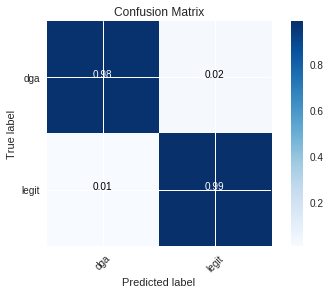

In [20]:
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
    
cm = cm.astype('float') / cm.sum(axis=1).T[:, np.newaxis]
    
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([1, 0], labels, rotation=45)
plt.yticks([1, 0], labels)
    
fmt = '.2f'
thresh = cm.max() / 2.
for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, format(cm[i, j], fmt),
  horizontalalignment="center",
  color="white" if cm[i, j] > thresh else "black")
    
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()